In [27]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [28]:
df_test = pd.read_csv("../data/test.csv") # neobsahuje target
df = pd.read_parquet("../data/train_after_eda.parquet")
df = df.drop(columns="base_price")
df.head(3)

,id,week,center_id,meal_id,checkout_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,total_sale
0,1379560,1,55,1885,136.83,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,26955.33
1,1466964,1,55,1993,136.83,0,0,270,Beverages,Thai,647,56,TYPE_C,2.0,36674.10
2,1346989,1,55,2539,134.86,0,0,189,Beverages,Thai,647,56,TYPE_C,2.0,25677.54


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   emailer_for_promotion  456548 non-null  int64  
 6   homepage_featured      456548 non-null  int64  
 7   num_orders             456548 non-null  int64  
 8   category               456548 non-null  object 
 9   cuisine                456548 non-null  object 
 10  city_code              456548 non-null  int64  
 11  region_code            456548 non-null  int64  
 12  center_type            456548 non-null  object 
 13  op_area                456548 non-null  float64
 14  total_sale             456548 non-nu

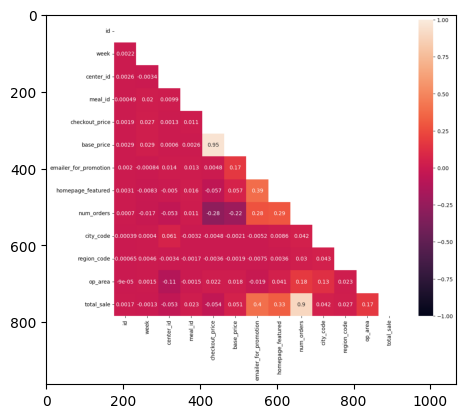

<Figure size 2000x2000 with 0 Axes>

In [30]:
import matplotlib.image as mpimg
image = mpimg.imread("../data/graphs/corr.png")
plot = plt.imshow(image)
plt.figure(figsize=(20, 20))
plt.show(plot)

1. We can see that nothing is much correlated in predictors except for base/checkout price -> we will remove that
2. Bc there is no evident order we will encode using One-Hot instead of OrdinalEncoder

In [31]:
df = df.sort_values(by = ['week']).reset_index(drop=True)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

PREDICTOR_COLUMS = [col for col in df.columns if col != "num_orders"]
train_df = df[df['week'] <= 120]
test_df = df[df['week'] >= 120]

X_train = train_df[PREDICTOR_COLUMS]
y_train = train_df[["num_orders"]]

X_test = test_df[PREDICTOR_COLUMS]
y_test = test_df[["num_orders"]]

In [33]:
CATEGORICAL_COLS = ["category", "cuisine", "center_type"]

ct = ColumnTransformer([('_encoder', OneHotEncoder(), CATEGORICAL_COLS)])

pipe = Pipeline([
    ('encoder', ct), 
    ('regression', LinearRegression()), 
])

model = pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)

#SCORE

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)

R2: 0.2682307472587876 	 MAE: 162.0727639502548 	 MSE: 97610.90492316597


In [34]:
CATEGORICAL_COLS = ["category", "cuisine", "center_type"]

ct = ColumnTransformer([('_encoder', OneHotEncoder(), CATEGORICAL_COLS)])

pipe = Pipeline([
    ('encoder', ct), 
    ('regression', DecisionTreeRegressor(random_state=1)), 
])

model = pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)

#SCORE

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)

R2: 0.2884613796632761 	 MAE: 154.68581306988423 	 MSE: 94912.33521861403


## Idea time
1. remove outlier -> both negatively affect regression

In [35]:
df

,id,week,center_id,meal_id,checkout_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,total_sale
0,1379560,1,55,1885,136.83,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,26955.33
1,1362208,1,72,2704,251.29,0,1,80,Other Snacks,Thai,638,56,TYPE_C,3.9,22586.40
2,1060796,1,72,2492,387.03,0,1,82,Desert,Indian,638,56,TYPE_C,3.9,31900.46
3,1390499,1,72,2304,484.03,0,0,13,Desert,Indian,638,56,TYPE_C,3.9,6318.39
4,1472526,1,67,1885,135.86,0,0,1958,Beverages,Thai,638,56,TYPE_B,7.0,264055.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456543,1410777,145,137,1902,447.23,0,0,68,Biryani,Indian,590,56,TYPE_A,4.4,30275.64
456544,1177783,145,137,1247,446.23,0,0,28,Biryani,Indian,590,56,TYPE_A,4.4,12522.44
456545,1342527,145,137,1770,485.03,0,0,42,Biryani,Indian,590,56,TYPE_A,4.4,20329.26
456546,1384799,145,137,2640,320.13,0,0,121,Starters,Thai,590,56,TYPE_A,4.4,38735.73


In [36]:
from scipy import stats

z_scores = stats.zscore(df['total_sale'])
threshold = 3
df_no_outliers = df[(z_scores < threshold) & (z_scores > -threshold)]
PREDICTOR_COLUMS = [col for col in df_no_outliers.columns if col != "num_orders"]

train_df = df_no_outliers[df_no_outliers['week'] <= 120]
test_df = df_no_outliers[df_no_outliers['week'] >= 120]

X_train = train_df[PREDICTOR_COLUMS]
y_train = train_df[["num_orders"]]

X_test = test_df[PREDICTOR_COLUMS]
y_test = test_df[["num_orders"]]

In [37]:
CATEGORICAL_COLS = ["category", "cuisine", "center_type"]

ct = ColumnTransformer([('_encoder', OneHotEncoder(), CATEGORICAL_COLS)])

pipe = Pipeline([
    ('encoder', ct), 
    ('regression', LinearRegression()), 
])

model = pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)

#SCORE

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)

R2: 0.3624754876765446 	 MAE: 134.07766082494066 	 MSE: 43057.98815257462


In [38]:
CATEGORICAL_COLS = ["category", "cuisine", "center_type"]

ct = ColumnTransformer([('_encoder', OneHotEncoder(), CATEGORICAL_COLS)])

pipe = Pipeline([
    ('encoder', ct), 
    ('regression', DecisionTreeRegressor(random_state=1)), 
])

model = pipe.fit(X_train, y_train)
y_pred = model.predict(X_test)

#SCORE

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)

R2: 0.3928566241108319 	 MAE: 127.65020318429427 	 MSE: 41006.06608940289


In [39]:
for col in CATEGORICAL_COLS:
    encoder = OneHotEncoder()
    encoded_values = encoder.fit_transform(df[[col]])
    encoded_df = pd.DataFrame(encoded_values.toarray(), columns=encoder.get_feature_names_out([col]))
    df_encoded = pd.concat([df, encoded_df], axis=1)
    
OTHER_COLS = [col for col in df.columns if col not in CATEGORICAL_COLS]
df_encoded = df_encoded[OTHER_COLS]

In [40]:
PREDICTOR_COLUMS = [col for col in df_encoded.columns if col != "num_orders"]
train_df = df_encoded[df_encoded['week'] <= 120]
test_df = df_encoded[df_encoded['week'] >= 120]

X_train_enc = train_df[PREDICTOR_COLUMS]
y_train_enc = train_df[["num_orders"]]

X_test_enc = test_df[PREDICTOR_COLUMS]
y_test_enc = test_df[["num_orders"]]

In [41]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

rlm_model = sm.RLM(y_train_enc, sm.add_constant(X_train_enc)).fit()
y_pred = rlm_model.predict(sm.add_constant(X_test_enc))

r2 = r2_score(y_test_enc, y_pred)
mae = mean_absolute_error(y_test_enc, y_pred)
mse = mean_squared_error(y_test_enc, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)

R2: 0.8700461903168097 	 MAE: 64.88020486839154 	 MSE: 17334.574954975673


In [43]:
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust hyperparameters like n_estimators
random_forest.fit(X_train_enc, y_train_enc)
y_pred = random_forest.predict(X_test_enc)

r2 = r2_score(y_test_enc, y_pred)
mae = mean_absolute_error(y_test_enc, y_pred)
mse = mean_squared_error(y_test_enc, y_pred)

print(
    f"R2: {r2} \t MAE: {mae} \t MSE: {mse}" 
)


/var/folders/3b/xyq4srtx5gl95073r1qm5v_w0000gn/T/ipykernel_19484/128945246.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  random_forest.fit(X_train_enc, y_train_enc)


KeyboardInterrupt: 

In [ ]:
importances = random_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_forest.estimators_], axis=0)

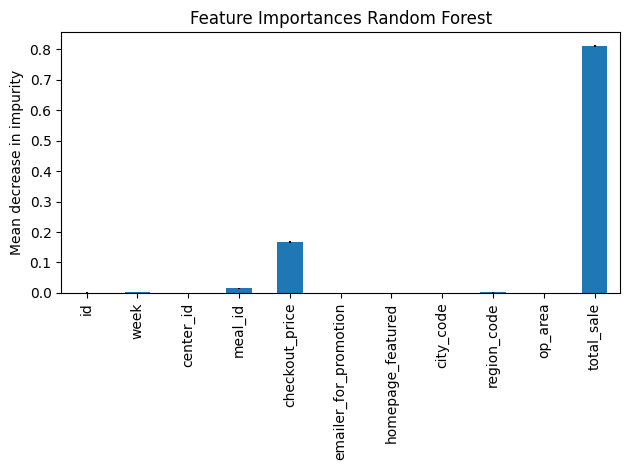

In [ ]:
forest_importances = pd.Series(importances, index=X_test_enc.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances Random Forest")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()